
# **Data Preprocessing**

In [1]:
import pickle as pickle
import random
from random import *
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import os
from collections import defaultdict
import sys, re
import pandas as pd
from PIL import Image
import math
from types import *
from gensim.models import Word2Vec
import jieba
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import os.path
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount="True")

Mounted at /content/drive


Text Preprocessing Pipeline, where where stopwords are removed and text is cleaned before further analysis or processing

In [3]:
def stopwordslist(filepath = '/content/drive/MyDrive/WEIBO Dataset/EANN-KDD18-master/data/weibo/stop_words.txt'):
    stopwords = {}
    for line in open(filepath, 'r',encoding='utf-8').readlines():
        # line = unicode(line, "utf-8").strip()
        line = line.strip()
        stopwords[line] = 1
    #stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

def clean_str_sst(string):
    string = re.sub(u"[，。 :,.；|-“”——_/nbsp+&;@、《》～（）())#O！：【】]", "", string)
    return string.strip().lower()

Read and Preprocess Image Data

In [4]:
def read_image():
    image_list = {}
    file_list = ['/content/drive/MyDrive/WEIBO Dataset/EANN-KDD18-master/data/weibo/nonrumor_images/', '/content/drive/MyDrive/WEIBO Dataset/EANN-KDD18-master/data/weibo/rumor_images/']
    for path in file_list:
        data_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        for i, filename in enumerate(os.listdir(path)):  # assuming gif

            # print(filename)
            # try:
              im = Image.open(path + filename).convert('RGB')
              im = data_transforms(im)
                  #im = 1
              image_list[filename.split('/')[-1].split(".")[0].lower()] = im
            # except:
            #     print(filename)
    # print("image length " + str(len(image_list)))
    #print("image names are " + str(image_list.keys()))
    return image_list

Write contents of 'data' into a text file

In [5]:
def write_txt(data):
    f = open("/content/drive/MyDrive/WEIBO Dataset/EANN-KDD18-master/data/weibo/top_n_data.txt", 'wb')
    for line in data:
        for l in line:
            f.write(l+"\n")
        f.write("\n")
        f.write("\n")
    f.close()

Organizing and preparing text and image data for further processing

In [6]:
text_dict = {}
def write_data(flag, image, text_only):

    def read_post(flag):
        stop_words = stopwordslist()
        pre_path = "/content/drive/MyDrive/WEIBO Dataset/EANN-KDD18-master/data/weibo/tweets/"
        file_list = [pre_path + "test_nonrumor.txt", pre_path + "test_rumor.txt", \
                         pre_path + "train_nonrumor.txt", pre_path + "train_rumor.txt"]
        if flag == "train":
            id = pickle.load(open("/content/drive/MyDrive/WEIBO Dataset/EANN-KDD18-master/data/weibo/train_id.pickle", 'rb'))
        elif flag == "validate":
            id = pickle.load(open("/content/drive/MyDrive/WEIBO Dataset/EANN-KDD18-master/data/weibo/validate_id.pickle", 'rb'))
        elif flag == "test":
            id = pickle.load(open("/content/drive/MyDrive/WEIBO Dataset/EANN-KDD18-master/data/weibo/test_id.pickle", 'rb'))


        post_content = []
        labels = []
        image_ids = []
        twitter_ids = []
        data = []
        column = ['post_id', 'image_id', 'original_post', 'post_text', 'label', 'event_label']
        key = -1
        map_id = {}
        top_data = []
        for k, f in enumerate(file_list):

            f = open(f, 'r',  encoding='utf-8')
            if (k + 1) % 2 == 1:
                label = 0  ### real is 0
            else:
                label = 1  ####fake is 1

            twitter_id = 0
            line_data = []
            top_line_data = []

            for i, l in enumerate(f.readlines()):

                if (i + 1) % 3 == 1:
                    line_data = []
                    twitter_id = l.split('|')[0]
                    line_data.append(twitter_id)



                if (i + 1) % 3 == 2:

                    line_data.append(l.lower())

                if (i + 1) % 3 == 0:
                    l = clean_str_sst(l)

                    seg_list = jieba.cut_for_search(l)
                    new_seg_list = []
                    for word in seg_list:
                        if word not in stop_words:
                            new_seg_list.append(word)

                    clean_l = " ".join(new_seg_list)
                    if len(clean_l) > 10 and line_data[0] in id:
                        post_content.append(l)
                        line_data.append(l)
                        line_data.append(clean_l)
                        line_data.append(label)
                        event = int(id[line_data[0]])
                        if event not in map_id:
                            map_id[event] = len(map_id)
                            event = map_id[event]
                        else:
                            event = map_id[event]

                        line_data.append(event)

                        data.append(line_data)


            f.close()

        data_df = pd.DataFrame(np.array(data), columns=column)
        write_txt(top_data)

        return post_content, data_df

    post_content, post = read_post(flag)
    print("Original post length is " + str(len(post_content)))
    print("Original data frame is " + str(post.shape))


    def find_most(db):
        maxcount = max(len(v) for v in db.values())
        return [k for k, v in db.items() if len(v) == maxcount]

    def select(train, selec_indices):
        temp = []
        for i in range(len(train)):
            ele = list(train[i])
            temp.append([ele[i] for i in selec_indices])
            #   temp.append(np.array(train[i])[selec_indices])
        return temp

    def paired(text_only = False):
        ordered_image = []
        ordered_text = []
        ordered_post = []
        ordered_event= []
        label = []
        post_id = []
        image_id_list = []

        image_id = ""
        for i, id in enumerate(post['post_id']):
            for image_id in post.iloc[i]['image_id'].split('|'):
                image_id = image_id.split("/")[-1].split(".")[0]
                if image_id in image:
                    break

            if text_only or image_id in image:
                if not text_only:
                    image_name = image_id
                    image_id_list.append(image_name)
                    ordered_image.append(image[image_name])
                ordered_text.append(post.iloc[i]['original_post'])
                ordered_post.append(post.iloc[i]['post_text'])
                ordered_event.append(post.iloc[i]['event_label'])
                post_id.append(id)


                label.append(post.iloc[i]['label'])

        label = np.array(label, dtype=int)
        ordered_event = np.array(ordered_event, dtype=int)

        print("Label number is " + str(len(label)))
        print("Rummor number is " + str(sum(label)))
        print("Non rummor is " + str(len(label) - sum(label)))




        if flag == "test":
            y = np.zeros(len(ordered_post))
        else:
            y = []


        data = {"post_text": np.array(ordered_post),
                "original_post": np.array(ordered_text),
                "image": ordered_image, "social_feature": [],
                "label": np.array(label), \
                "event_label": ordered_event, "post_id":np.array(post_id),
                "image_id":image_id_list}


        print("data size is " + str(len(data["post_text"])))

        return data

    paired_data = paired(text_only)

    print("paired post length is "+str(len(paired_data["post_text"])))
    print("paried data has " + str(len(paired_data)) + " dimension")
    return paired_data

Preparing vocabulary and text data from train, validate and test dataset

In [7]:
def Load_data(train, validate, test):
    vocab = defaultdict(float)
    all_text = list(train['post_text']) + list(validate['post_text'])+list(test['post_text'])
    for sentence in all_text:
        for word in sentence:
            vocab[word] += 1
    print(len(all_text),"*************")
    return vocab, all_text

Loading text data and Creating word embeddings

In [8]:
## 10 folds cross validation ##
def build_data_cv(data_folder, cv=10, clean_string=True):
    """
    Loads data and split into 10 folds.
    """
    revs = []
    pos_file = data_folder[0]
    neg_file = data_folder[1]
    vocab = defaultdict(float)
    with open(pos_file, "rb") as f:
        for line in f:
            rev = []
            rev.append(line.strip())
            if clean_string:
                orig_rev = str(" ".join(rev))
            else:
                orig_rev = " ".join(rev).lower()
            words = set(orig_rev.split())
            for word in words:
                vocab[word] += 1
            datum = {"y": 1,
                     "text": orig_rev,
                     "num_words": len(orig_rev.split()),
                     "split": np.random.randint(0, cv)}
            revs.append(datum)
    with open(neg_file, "rb") as f:
        for line in f:
            rev = []
            rev.append(line.strip())
            if clean_string:
                orig_rev =str(" ".join(rev))
            else:
                orig_rev = " ".join(rev).lower()
            words = set(orig_rev.split())
            for word in words:
                vocab[word] += 1
            datum = {"y": 0,
                     "text": orig_rev,
                     "num_words": len(orig_rev.split()),
                     "split": np.random.randint(0, cv)}
            revs.append(datum)
    return revs, vocab

## constructs word matrix from given word vector ##
def get_W(word_vecs, k=32):
    """
    Get word matrix. W[i] is the vector for word indexed by i
    """
    word_idx_map = dict()
    W = np.zeros(shape=(len(word_vecs) + 1, k), dtype='float32')
    W[0] = np.zeros(k, dtype='float32')
    i = 1
    for word in word_vecs:
        W[i] = word_vecs[word]
        word_idx_map[word] = i
        i += 1
    return W, word_idx_map


def load_bin_vec(fname, vocab):
    """
    Loads 300x1 word vecs from Google (Mikolov) word2vec
    """
    word_vecs = {}
    with open(fname, "rb") as f:
        header = f.readline()
        vocab_size, layer1_size = map(int, header.split())
        binary_len = np.dtype('float32').itemsize * layer1_size
        for line in range(vocab_size):
            word = []
            while True:
                ch = f.read(1)
                if ch == ' ':
                    word = ''.join(word)
                    break
                if ch != '\n':
                    word.append(ch)
            if word in vocab:
                word_vecs[word] = np.fromstring(f.read(binary_len), dtype='float32')
            else:
                f.read(binary_len)
    return word_vecs


def add_unknown_words(word_vecs, vocab, min_df=1, k=32):
    """
    For words that occur in at least min_df documents, create a separate word vector.
    0.25 is chosen so the unknown vectors have (approximately) same variance as pre-trained ones
    """
    print(type(word_vecs))
    for word in vocab:
        if word not in word_vecs and vocab[word] >= min_df:
            word_vecs[word] = np.random.uniform(-0.25, 0.25, k)



def get_data(text_only):

    if text_only:
        print("Text only")
        image_list = []
    else:
        print("Text and image")
        image_list = read_image()

    train_data = write_data("train", image_list, text_only)
    valiate_data = write_data("validate", image_list, text_only)
    test_data = write_data("test", image_list, text_only)
    print(len(train_data),"***********")
    print("loading data...")
    vocab, all_text = Load_data(train_data, valiate_data, test_data)
    print("len all_text",str(len(all_text)))

    print("number of sentences: " + str(len(all_text)))
    print("vocab size: " + str(len(vocab)))
    max_l = len(max(all_text, key=len))
    print("max sentence length: " + str(max_l))

    file = open("/content/drive/MyDrive/WEIBO Dataset/w2v (1).pickle", 'r')

    # Read the content of the file
    content = file.read()

    # Close the file
    file.close()

    # Encode the content to UTF-8
    w2v = content.encode("utf-8")

    print(type(w2v))

    print("word2vec loaded!")
    print("num words already in word2vec: " + str(len(w2v)))
    W, word_idx_map = get_W(w2v)
    rand_vecs = {}
    add_unknown_words(rand_vecs, vocab)
    W2 = rand_vecs = {}
    w_file = open("/content/drive/MyDrive/WEIBO Dataset/EANN-KDD18-master/data/weibo/word_embedding.pickle", "wb")
    pickle.dump([W, W2, word_idx_map, vocab, max_l], w_file)
    w_file.close()
    return train_data, valiate_data, test_data





# **EANN: Event Adversarial Neural Network Model**


In [9]:
import numpy as np
import argparse
import time, os
import copy
import pickle as pickle
from random import sample
import torchvision
from sklearn.model_selection import train_test_split
import torch
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR
import torch.nn as nn
from torch.autograd import Variable, Function
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn import metrics
from sklearn.preprocessing import label_binarize
import scipy.io as sio

Preparing Rumor Dataset

In [10]:
class Rumor_Data(Dataset):
    def __init__(self, dataset):
        self.text = torch.from_numpy(np.array(dataset['post_text']))
        self.image = list(dataset['image'])
        self.mask = torch.from_numpy(np.array(dataset['mask']))
        self.label = torch.from_numpy(np.array(dataset['label']))
        self.event_label = torch.from_numpy(np.array(dataset['event_label']))
        print('TEXT: %d, Image: %d, labe: %d, Event: %d'
               % (len(self.text), len(self.image), len(self.label), len(self.event_label)))

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return (self.text[idx], self.image[idx], self.mask[idx]), self.label[idx], self.event_label[idx]



Gradient reversal for domain adaptation

In [11]:
class ReverseLayerF(Function):
    def forward(ctx, x, lambd):
        # Save lambd for use in backward pass
        ctx.lambd = lambd
        return x.view_as(x)

    def backward(ctx, grad_output):
        # Retrieve lambd from the context
        lambd = ctx.lambd
        # Scale the gradient by -lambd
        return (grad_output * -lambd), None

def grad_reverse(x, lambd):
    return ReverseLayerF.apply(x, lambd)

Text data is processed using an embedding layer and a convolutional neural network (CNN), while the image data is processed through a pre-trained VGG19 network.

In [12]:
# Neural Network Model (1 hidden layer)
class CNN_Fusion(nn.Module):
    # def __init__(self, args, W):
    def __init__(self, args):
        super(CNN_Fusion, self).__init__()
        self.args = args

        self.event_num = args.event_num

        vocab_size = args.vocab_size
        emb_dim = args.embed_dim

        C = args.class_num
        self.hidden_size = args.hidden_dim
        self.lstm_size = args.embed_dim
        self.social_size = 19

        # TEXT RNN
        self.embed = nn.Embedding(vocab_size, emb_dim)
        # self.embed.weight = nn.Parameter(torch.from_numpy(W))
        self.lstm = nn.LSTM(self.lstm_size, self.lstm_size)
        self.text_fc = nn.Linear(self.lstm_size, self.hidden_size)
        self.text_encoder = nn.Linear(emb_dim, self.hidden_size)

        ### TEXT CNN
        channel_in = 1
        filter_num = 20
        window_size = [1, 2, 3, 4]
        self.convs = nn.ModuleList([nn.Conv2d(channel_in, filter_num, (K, emb_dim)) for K in window_size])
        self.fc1 = nn.Linear(len(window_size) * filter_num, self.hidden_size)

        self.dropout = nn.Dropout(args.dropout)

        #IMAGE
        #hidden_size = args.hidden_dim
        vgg_19 = torchvision.models.vgg19(pretrained=True)
        for param in vgg_19.parameters():
            param.requires_grad = False
        # visual model
        num_ftrs = vgg_19.classifier._modules['6'].out_features
        self.vgg = vgg_19
        self.image_fc1 = nn.Linear(num_ftrs,  self.hidden_size)
        #self.image_fc2 = nn.Linear(512, self.hidden_size)
        self.image_adv = nn.Linear(self.hidden_size,  int(self.hidden_size))
        self.image_encoder = nn.Linear(self.hidden_size, self.hidden_size)

        ###social context
        self.social = nn.Linear(self.social_size, self.hidden_size)

        ##ATTENTION
        self.attention_layer = nn.Linear(self.hidden_size, emb_dim)

        ## Class  Classifier
        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(2 * self.hidden_size, 2))
        self.class_classifier.add_module('c_softmax', nn.Softmax(dim=1))

        ###Event Classifier
        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(2 * self.hidden_size, self.hidden_size))
        #self.domain_classifier.add_module('d_bn1', nn.BatchNorm2d(self.hidden_size))
        self.domain_classifier.add_module('d_relu1', nn.LeakyReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(self.hidden_size, self.event_num))
        self.domain_classifier.add_module('d_softmax', nn.Softmax(dim=1))

    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (to_var(torch.zeros(1, batch_size, self.lstm_size)),
                to_var(torch.zeros(1, batch_size, self.lstm_size)))

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (sample number,hidden_dim, length)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)

        return x

    def forward(self, text, image,  mask):
        ### IMAGE #####
        image = self.vgg(image) #[N, 512]
        image = F.leaky_relu(self.image_fc1(image))

        ##########CNN##################
        text = self.embed(text)
        text = text * mask.unsqueeze(2).expand_as(text)
        text = text.unsqueeze(1)
        text = [F.leaky_relu(conv(text)).squeeze(3) for conv in self.convs]  # [(N,hidden_dim,W), ...]*len(window_size)
        text = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in text]
        text = torch.cat(text, 1)
        text = F.leaky_relu(self.fc1(text))
        text_image = torch.cat((text, image), 1)

        ### Fake or real
        class_output = self.class_classifier(text_image)
        ## Domain (which Event )
        lambd=0.5
        reverse_feature = grad_reverse(text_image,lambd)
        domain_output = self.domain_classifier(reverse_feature)
        return class_output, domain_output

Handling PyTorch tensors, variable conversions, data splitting, and class weighting calculation

In [13]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


def to_np(x):
    return x.data.cpu().numpy()

def select(train, selec_indices):
    temp = []
    for i in range(len(train)):
        print("length is "+str(len(train[i])))
        print(i)
        ele = list(train[i])
        temp.append([ele[i] for i in selec_indices])
    return temp

def make_weights_for_balanced_classes(event, nclasses = 15):
    count = [0] * nclasses
    for item in event:
        count[item] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(event)
    for idx, val in enumerate(event):
        weight[idx] = weight_per_class[val]
    return weight

def split_train_validation(train, percent):
    whole_len = len(train[0])

    train_indices = (sample(range(whole_len), int(whole_len * percent)))
    train_data = select(train, train_indices)
    print("train data size is "+ str(len(train[3])))

    validation = select(train, np.delete(range(len(train[0])), train_indices))
    print("validation size is "+ str(len(validation[3])))
    print("train and validation data set has been splited")


    return train_data, validation

Main thread and evaluation loop

In [14]:
def main(args):
    print('loading data')
    train, validation, test = load_data(args)

    test_id = test['post_id']
    train_dataset = Rumor_Data(train)

    validate_dataset = Rumor_Data(validation)

    test_dataset = Rumor_Data(test)

    # Data Loader (Input Pipeline)
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=args.batch_size,
                              shuffle=True)

    validate_loader = DataLoader(dataset = validate_dataset,
                                 batch_size=args.batch_size,
                                 shuffle=False)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=args.batch_size,
                             shuffle=False)

    print('building model')
    model = CNN_Fusion(args)

    if torch.cuda.is_available():
        print("CUDA")
        model.cuda()

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, list(model.parameters())),
                                 lr= args.learning_rate)

    iter_per_epoch = len(train_loader)
    print("loader size " + str(len(train_loader)))
    best_validate_acc = 0.000
    best_test_acc = 0.000
    best_loss = 100
    best_validate_dir = ''
    best_list = [0,0]

    print('training model')
    adversarial = True
    # Train the Model
    for epoch in range(args.num_epochs):

        p = float(epoch) / 100
        #lambd = 2. / (1. + np.exp(-10. * p)) - 1
        lr = 0.001 / (1. + 10 * p) ** 0.75

        optimizer.lr = lr
        #rgs.lambd = lambd
        start_time = time.time()
        cost_vector = []
        class_cost_vector = []
        domain_cost_vector = []
        acc_vector = []
        valid_acc_vector = []
        test_acc_vector = []
        vali_cost_vector = []
        test_cost_vector = []

        for i, (train_data, train_labels, event_labels) in enumerate(train_loader):
            train_text, train_image,  train_mask, train_labels, event_labels = \
                to_var(train_data[0]), to_var(train_data[1]), to_var(train_data[2]), \
                to_var(train_labels), to_var(event_labels)

            # Forward + Backward + Optimize
            optimizer.zero_grad()

            class_outputs, domain_outputs = model(train_text, train_image, train_mask)

            ## Fake or Real loss
            class_loss = criterion(class_outputs, train_labels)
            # Event Loss
            domain_loss = criterion(domain_outputs, event_labels)
            loss = class_loss + domain_loss
            loss.backward()
            optimizer.step()
            _, argmax = torch.max(class_outputs, 1)

            cross_entropy = True

            if True:
                accuracy = (train_labels == argmax.squeeze()).float().mean()
            else:
                _, labels = torch.max(train_labels, 1)
                accuracy = (labels.squeeze() == argmax.squeeze()).float().mean()
            class_cost_vector.append(class_loss.item())
            domain_cost_vector.append(domain_loss.item())
            cost_vector.append(loss.item())
            acc_vector.append(accuracy.item())

        model.eval()
        validate_acc_vector_temp = []
        for i, (validate_data, validate_labels, event_labels) in enumerate(validate_loader):
            validate_text, validate_image,  validate_mask, validate_labels, event_labels = \
                to_var(validate_data[0]), to_var(validate_data[1]), to_var(validate_data[2]), \
                to_var(validate_labels), to_var(event_labels)
            validate_outputs, domain_outputs = model(validate_text, validate_image, validate_mask)
            _, validate_argmax = torch.max(validate_outputs, 1)
            vali_loss = criterion(validate_outputs, validate_labels)

            validate_accuracy = (validate_labels == validate_argmax.squeeze()).float().mean()
            vali_cost_vector.append( vali_loss.item())
            validate_acc_vector_temp.append(validate_accuracy.item())
        validate_acc = np.mean(validate_acc_vector_temp)
        valid_acc_vector.append(validate_acc)
        model.train()
        print ('Epoch [%d/%d],  Loss: %.4f, Class Loss: %.4f, domain loss: %.4f, Train_Acc: %.4f,  Validate_Acc: %.4f.'
                % (
                epoch + 1, args.num_epochs,  np.mean(cost_vector), np.mean(class_cost_vector),  np.mean(domain_cost_vector),
                    np.mean(acc_vector),   validate_acc))

        if validate_acc > best_validate_acc:
            best_validate_acc = validate_acc
            if not os.path.exists(args.output_file):
                os.mkdir(args.output_file)

            best_validate_dir = args.output_file + str(epoch + 1) + '.pkl'
            torch.save(model.state_dict(), best_validate_dir)

        duration = time.time() - start_time

    print('testing model')
    model = CNN_Fusion(args)
    model.load_state_dict(torch.load(best_validate_dir))
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    test_score = []
    test_pred = []
    test_true = []
    for i, (test_data, test_labels, event_labels) in enumerate(test_loader):
        test_text, test_image, test_mask, test_labels = to_var(
            test_data[0]), to_var(test_data[1]), to_var(test_data[2]), to_var(test_labels)
        test_outputs, domain_outputs= model(test_text, test_image, test_mask)
        _, test_argmax = torch.max(test_outputs, 1)
        if i == 0:
            test_score = to_np(test_outputs.squeeze())
            test_pred = to_np(test_argmax.squeeze())
            test_true = to_np(test_labels.squeeze())
        else:
            test_score = np.concatenate((test_score, to_np(test_outputs.squeeze())), axis=0)
            test_pred = np.concatenate((test_pred, to_np(test_argmax.squeeze())), axis=0)
            test_true = np.concatenate((test_true, to_np(test_labels.squeeze())), axis=0)

    test_accuracy = metrics.accuracy_score(test_true, test_pred)
    test_f1 = metrics.f1_score(test_true, test_pred, average='macro')
    test_precision = metrics.precision_score(test_true, test_pred, average='macro')
    test_recall = metrics.recall_score(test_true, test_pred, average='macro')
    test_score_convert = [x[1] for x in test_score]
    test_aucroc = metrics.roc_auc_score(test_true, test_score_convert, average='macro')

    test_confusion_matrix = metrics.confusion_matrix(test_true, test_pred)

    print("Classification Acc: %.4f, AUC-ROC: %.4f"
          % (test_accuracy, test_aucroc))
    print("Classification report:\n%s\n"
          % (metrics.classification_report(test_true, test_pred)))
    print("Classification confusion matrix:\n%s\n"
          % (test_confusion_matrix))
    classes = ('Non rumor','Rumor')
    df_cm = pd.DataFrame(test_confusion_matrix.astype('float')/test_confusion_matrix.sum(axis=1)[:, np.newaxis], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('output.png')


Defining and parsing command-line arguments for training and testing

In [15]:
def parse_arguments(parser):
    parser.add_argument('training_file', type=str, metavar='<training_file>', help='')
    parser.add_argument('testing_file', type=str, metavar='<testing_file>', help='')
    parser.add_argument('output_file', type=str, metavar='<output_file>', help='')

    parse.add_argument('--static', type=bool, default=True, help='')
    parser.add_argument('--sequence_length', type=int, default=28, help='')
    parser.add_argument('--class_num', type=int, default=2, help='')
    parser.add_argument('--hidden_dim', type=int, default = 32, help='')
    parser.add_argument('--embed_dim', type=int, default=32, help='')
    parser.add_argument('--vocab_size', type=int, default=300, help='')
    parser.add_argument('--dropout', type=int, default=0.5, help='')
    parser.add_argument('--filter_num', type=int, default=5, help='')
    parser.add_argument('--lambd', type=int, default= 1, help='')
    parser.add_argument('--text_only', type=bool, default= False, help='')


    parser.add_argument('--d_iter', type=int, default=3, help='')
    parser.add_argument('--batch_size', type=int, default=100, help='')
    parser.add_argument('--num_epochs', type=int, default=10, help='')
    parser.add_argument('--learning_rate', type=float, default=0.001, help='')
    parser.add_argument('--event_num', type=int, default=10, help='')

    return parser

Returns the top posts based on predicted probabilities and labels

In [16]:
def get_top_post(output, label, test_id, top_n = 500):
    filter_output = []
    filter_id = []

    for i, l in enumerate(label):
        if np.argmax(output[i]) == l and int(l) == 1 :
            filter_output.append(output[i][1])
            filter_id.append(test_id[i])

    filter_output = np.array(filter_output)

    top_n_indice = filter_output.argsort()[-top_n:][::-1]

    top_n_id = np.array(filter_id)[top_n_indice]
    top_n_id_dict = {}
    for i in top_n_id:
        top_n_id_dict[i] = True

    pickle.dump(top_n_id_dict, open("../Data/weibo/top_n_id.pickle", "wb"))

    return top_n_id

Generating word embeddings for posts and creates masks for padding

In [17]:
def word2vec(post, word_id_map, W):
    word_embedding = []
    mask = []
    unknown_word_id = len(word_id_map)  # Assign a unique ID greater than the maximum ID in your vocabulary

    for sentence in post:
        sen_embedding = []
        mask_seq = np.zeros(args.sequence_len, dtype=np.float32)
        mask_seq[:len(sentence)] = 1.0

        for word in sentence:
            if word in word_id_map:
                sen_embedding.append(word_id_map[word])
            else:
                # Handle out-of-vocabulary words
                # For example, you can assign a special ID for unknown words
                sen_embedding.append(unknown_word_id)

        # Pad the sentence embedding if its length is less than args.sequence_len
        while len(sen_embedding) < args.sequence_len:
            sen_embedding.append(0)  # Padding token ID

        word_embedding.append(copy.deepcopy(sen_embedding))
        mask.append(copy.deepcopy(mask_seq))

    return word_embedding, mask


Loading and preprocessing the data for training, validation, and testing. Applying word embedding and creates masks for padding.

loading data
Text and image


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.952 seconds.
DEBUG:jieba:Loading model cost 0.952 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


Original post length is 2329
Original data frame is (2329, 6)
Label number is 43
Rummor number is 15
Non rummor is 28
data size is 43
paired post length is 43
paried data has 8 dimension
Original post length is 340
Original data frame is (340, 6)
Label number is 11
Rummor number is 7
Non rummor is 4
data size is 11
paired post length is 11
paried data has 8 dimension
Original post length is 686
Original data frame is (686, 6)
Label number is 20
Rummor number is 5
Non rummor is 15
data size is 20
paired post length is 20
paried data has 8 dimension
8 ***********
loading data...
74 *************
len all_text 74
number of sentences: 74
vocab size: 1307
max sentence length: 255
<class 'bytes'>
word2vec loaded!
num words already in word2vec: 1907002
<class 'dict'>
translate data to embedding
translate test data to embedding
sequence length 28
Train Data Size is 43
Finished loading data 
TEXT: 43, Image: 43, labe: 43, Event: 43
TEXT: 11, Image: 11, labe: 11, Event: 11
TEXT: 20, Image: 20, la

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 77.9MB/s]


loader size 1
training model
Epoch [1/10],  Loss: 2.9716, Class Loss: 0.6632, domain loss: 2.3084, Train_Acc: 0.6279,  Validate_Acc: 0.3636.
Epoch [2/10],  Loss: 2.9126, Class Loss: 0.5990, domain loss: 2.3137, Train_Acc: 0.7209,  Validate_Acc: 0.3636.
Epoch [3/10],  Loss: 2.8743, Class Loss: 0.5613, domain loss: 2.3130, Train_Acc: 0.7674,  Validate_Acc: 0.6364.
Epoch [4/10],  Loss: 2.8394, Class Loss: 0.5266, domain loss: 2.3128, Train_Acc: 0.7907,  Validate_Acc: 0.7273.
Epoch [5/10],  Loss: 2.8122, Class Loss: 0.4957, domain loss: 2.3165, Train_Acc: 0.8140,  Validate_Acc: 0.7273.
Epoch [6/10],  Loss: 2.8031, Class Loss: 0.4824, domain loss: 2.3207, Train_Acc: 0.8140,  Validate_Acc: 0.7273.
Epoch [7/10],  Loss: 2.8011, Class Loss: 0.4790, domain loss: 2.3221, Train_Acc: 0.8372,  Validate_Acc: 0.7273.
Epoch [8/10],  Loss: 2.7625, Class Loss: 0.4450, domain loss: 2.3174, Train_Acc: 0.8605,  Validate_Acc: 0.6364.
Epoch [9/10],  Loss: 2.7595, Class Loss: 0.4358, domain loss: 2.3237, Train

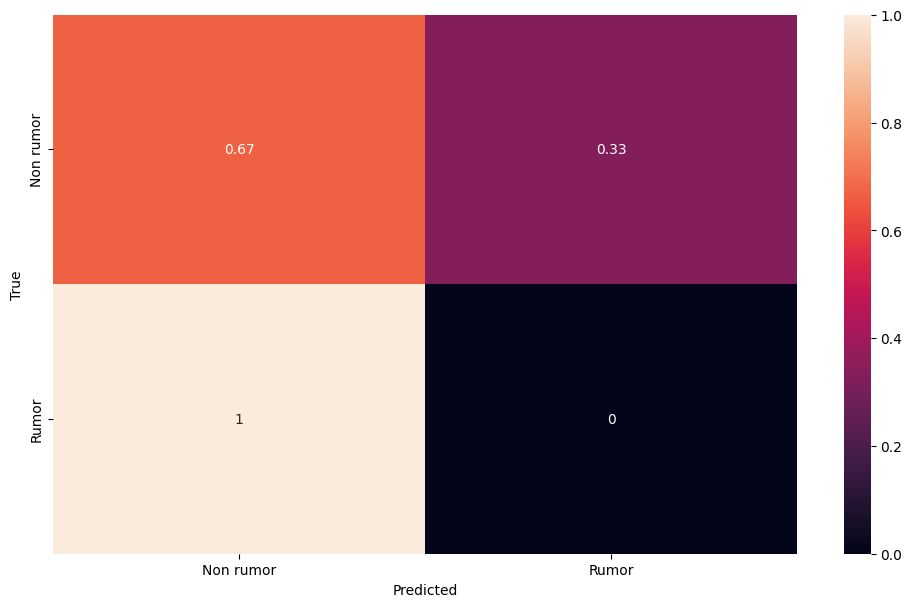

In [18]:
def load_data(args):
    train, validate, test = get_data(args.text_only)
    word_vector_path = '/content/drive/MyDrive/WEIBO Dataset/EANN-KDD18-master/data/weibo/word_embedding.pickle'
    f = open(word_vector_path, 'rb')
    weight = pickle.loads(f.read())  # W, W2, word_idx_map, vocab


    W, W2, word_idx_map, vocab, max_len = weight[0], weight[1], weight[2], weight[3], weight[4]
    args.vocab_size = len(vocab)
    args.sequence_len = max_len
    print("translate data to embedding")

    word_embedding, mask = word2vec(validate['post_text'], word_idx_map, W)
    validate['post_text'] = word_embedding
    validate['mask'] = mask


    print("translate test data to embedding")
    word_embedding, mask = word2vec(test['post_text'], word_idx_map, W)
    test['post_text'] = word_embedding
    test['mask']=mask
    word_embedding, mask = word2vec(train['post_text'], word_idx_map, W)
    train['post_text'] = word_embedding
    train['mask'] = mask
    print("sequence length " + str(args.sequence_length))
    print("Train Data Size is "+str(len(train['post_text'])))
    print("Finished loading data ")
    return train, validate, test

def transform(event):
    matrix = np.zeros([len(event), max(event) + 1])
    for i, l in enumerate(event):
        matrix[i, l] = 1.00
    return matrix

if __name__ == '__main__':
    parse = argparse.ArgumentParser()
    parser = parse_arguments(parse)
    train = ''
    test = ''
    output = '/content/drive/MyDrive/WEIBO Dataset/EANN-KDD18-master/data/weiboRESULT/'
    args = parser.parse_args([train, test, output])

    main(args)
